In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import poppy

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


In [2]:
osys = poppy.OpticalSystem()
osys.add_pupil(poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.025, fov_arcsec=0.75)  # image plane coordinates in arcseconds



In [3]:
osys.planes[1].pixelscale

0.025

In [4]:
osys.input_wavefront().amplitude

DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [5]:
osys.intermediate_wfs

In [6]:
psf,intermediate = osys.propagate_mono(2e-6)

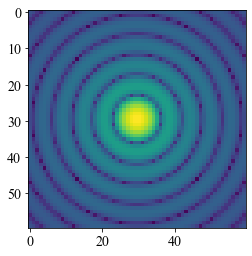

In [7]:
plt.imshow(psf.amplitude**0.25)

In [8]:
def objective(wavelength):
    psf,intermediate = osys.propagate_mono(wavelength*1e-6)   
    return (np.sum(psf.amplitude**2.))

objective(2.)

DeviceArray(0.96685994, dtype=float32)

In [9]:
thisgrad = grad(objective)
thisgrad(2.0)

DeviceArray(-0.01927825, dtype=float32)

In [10]:
%%time
print(thisgrad(2.0))

-0.019278252
CPU times: user 905 ms, sys: 203 ms, total: 1.11 s
Wall time: 877 ms


## Now can we calculate a UV plane?

In [11]:
from poppy.matrixDFT import minimal_dft

In [12]:
def calc_uv(wavefront,nlamD=32,npix=256):
    pupil = wavefront.amplitude**2.
    return minimal_dft(pupil, nlamD, npix)

In [13]:
uv = calc_uv(psf)

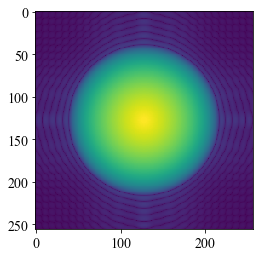

In [14]:
plt.imshow(np.abs(uv)**0.25)

In [15]:
wfe = poppy.ZernikeWFE(radius=1.0, coefficients=[0, 3e-8, 2e-7])


In [37]:
RADIUS = 1.0 # meters
WAVELENGTH = 460e-9 # meters
PIXSCALE = 0.02 # arcsec / pix
FOV = 2 # arcsec
NWAVES = 1.0


In [44]:
coefficients_sequence = [0, 0, 0, 0, 125e-9]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.add_pupil(thinlens)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(2e-6)

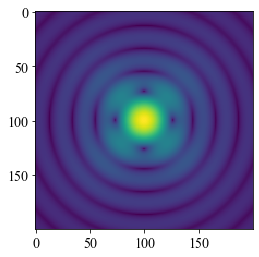

In [45]:
plt.imshow(psf.amplitude**0.5)